<a href="https://colab.research.google.com/github/azzabaatout/Mask-RCNN-TF2/blob/master/mask_rcnn_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETUP**

In [ ]:
!git clone https://github.com/azzabaatout/Mask-RCNN-TF2.git

In [ ]:
!pip3 install scikit-image==0.16.2
!pip3 install opencv-python

In [ ]:
!pip uninstall tensorflow -y
!pip uninstall keras -y
!pip install tensorflow-gpu==2.2.0
!pip install keras==2.3.1

In [ ]:
import tensorflow
import keras
import skimage

print(tensorflow.__version__)
print(keras.__version__)
print(skimage.__version__)

2.2.0
2.3.1
0.16.2


Using TensorFlow backend.


In [ ]:
!ls ./Mask-RCNN-TF2


assets	 MANIFEST.in			   mrcnn		     samples
FIRST	 maskrcnn_predict_directed.py	   mrcnn_directed	     setup.cfg
images	 maskrcnn_predict_directed_RPN.py  object-transfer-learning  setup.py
LICENSE  maskrcnn_predict.py		   requirements.txt	     test.jpg


In [ ]:
!ls ./Mask-RCNN-TF2/object-transfer-learning

object	object_prediction.py  object_training.py


In [ ]:
%cd ./Mask-RCNN-TF2/object-transfer-learning/object
!ls

/content/Mask-RCNN-TF2/object-transfer-learning/object
annots	train  val


# **List the Images in the images Directory**

**LIST THE FILES**

In [ ]:
!ls ./annots
!ls ./annots -l . | egrep -c '^-' # Count the number of files in the directory. 

annotations_train.json	annotations_val.json
2


In [ ]:
%cd ../..

/content/Mask-RCNN-TF2


**Training Steps**

In [ ]:
import os
import json
import xml.etree
from numpy import zeros, asarray

import mrcnn
import mrcnn.utils
import mrcnn.config
import mrcnn.model

class ObjectDataset(mrcnn.utils.Dataset):

    def load_dataset(self, annotation_json, images_dir, dataset_type="train"):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """

        # Load json from file
        print("Annotation json path: ", annotation_json)
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()

        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']

            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(
                    class_name))
                return

            self.add_class(source_name, class_id, class_name)

        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)

        # Get all images and add them to the dataset
        seen_images = {}

        # Split the dataset, if train, get 90%, else 10%
        len_images = len(coco_json['images'])
        if dataset_type == "train":
            img_range = [int(len_images / 9), len_images]
        else:
            img_range = [0, int(len_images / 9)]

        for i in range(img_range[0], img_range[1]):
            image = coco_json['images'][i]
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))

                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]

                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    # def load_dataset(self, dataset_dir, is_train=True):
    #     self.add_class("dataset", 1, "kangaroo")

    #     images_dir = dataset_dir + '/images/'
    #     annotations_dir = dataset_dir + '/annots/'

    #     for filename in os.listdir(images_dir):
    #         image_id = filename[:-4]

    #         if is_train and int(image_id) >= 150:
    #             continue

    #         if not is_train and int(image_id) < 150:
    #             continue

    #         img_path = images_dir + filename
    #         ann_path = annotations_dir + image_id + '.xml'

    #         self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []

        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        # print("Class_ids, ", class_ids)
        return mask, class_ids


    # def load_mask(self, image_id):
    #     info = self.image_info[image_id]
    #     path = info['annotation']
    #     boxes, w, h = self.extract_boxes(path)
    #     masks = zeros([h, w, len(boxes)], dtype='uint8')

    #     class_ids = list()
    #     for i in range(len(boxes)):
    #         box = boxes[i]
    #         row_s, row_e = box[1], box[3]
    #         col_s, col_e = box[0], box[2]
    #         masks[row_s:row_e, col_s:col_e, i] = 1
    #         class_ids.append(self.class_names.index('kangaroo'))
    #     return masks, asarray(class_ids, dtype='int32')

    # A helper method to extract the bounding boxes from the annotation file

    # def extract_boxes(self, filename):
    #     tree = xml.etree.ElementTree.parse(filename)

    #     root = tree.getroot()

    #     boxes = list()
    #     for box in root.findall('.//bndbox'):
    #         xmin = int(box.find('xmin').text)
    #         ymin = int(box.find('ymin').text)
    #         xmax = int(box.find('xmax').text)
    #         ymax = int(box.find('ymax').text)
    #         coors = [xmin, ymin, xmax, ymax]
    #         boxes.append(coors)

    #     width = int(root.find('.//size/width').text)
    #     height = int(root.find('.//size/height').text)
    #     return boxes, width, height

/content/Mask-RCNN-TF2/mrcnn/model.py:2370: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if os.name is 'nt':


In [ ]:
# Train
train_dataset = ObjectDataset()
train_dataset.load_dataset(annotation_json='./object-transfer-learning/object/annots/annotations_train.json', images_dir='./object-transfer-learning/object/train', dataset_type="train")
train_dataset.prepare()

# Validation
validation_dataset = ObjectDataset()
validation_dataset.load_dataset(annotation_json='./object-transfer-learning/object/annots/annotations_val.json', images_dir='./object-transfer-learning/object/val', dataset_type="val")
validation_dataset.prepare()

Annotation json path:  ./object-transfer-learning/object/annots/annotations_train.json
Annotation json path:  ./object-transfer-learning/object/annots/annotations_val.json


**EXTEND THE CONFIG CLASS**

In [ ]:
class ObjectConfig(mrcnn.config.Config):
    NAME = "object"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    NUM_CLASSES = 3 # bk + line + circle
    
    LEARNING_RATE = 0.001

    STEPS_PER_EPOCH = 100

In [ ]:
object_config = ObjectConfig()
object_config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

**BUILD MODEL**

In [ ]:
model = mrcnn.model.MaskRCNN(mode='training', 
                             model_dir='./log', 
                             config=object_config)
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

In [ ]:
import urllib.request

urllib.request.urlretrieve("https://github.com/matterport/Mask_RCNN/releases/download/v1.0/mask_rcnn_coco.h5", "mask_rcnn_coco.h5")

('mask_rcnn_coco.h5', <http.client.HTTPMessage at 0x7fb33e446d30>)

In [ ]:
model.load_weights(filepath='mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
print("Weights loaded!")

Weights loaded!


In [ ]:
from PIL import Image, ImageDraw, ImageFont
!pip install numpy
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**TRAIN**

In [ ]:
model.train(train_dataset=train_dataset, 
            val_dataset=validation_dataset, 
            learning_rate=object_config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: //logdir//train/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/keras/engine/training_generator.py:48: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  warnings.warn(


Epoch 1/5
100/100 [==============================] - 1184s 12s/step - loss: 1.5226 - val_loss: 2.8897
Epoch 2/5
100/100 [==============================] - 1152s 12s/step - loss: 1.2302 - val_loss: 1.8076
Epoch 3/5
100/100 [==============================] - 1157s 12s/step - loss: 1.6497 - val_loss: 1.9995
Epoch 4/5
100/100 [==============================] - 1134s 11s/step - loss: 1.3972 - val_loss: 1.4284
Epoch 5/5
100/100 [==============================] - 1149s 11s/step - loss: 2.3786 - val_loss: 2.0516


**SAVE WEIGHTS**

In [ ]:
model_path = 'object_mask_rcnn_trained.h5'
model.keras_model.save_weights(model_path)

**CODE FOR TRAINING**

**PREDICTIONS**

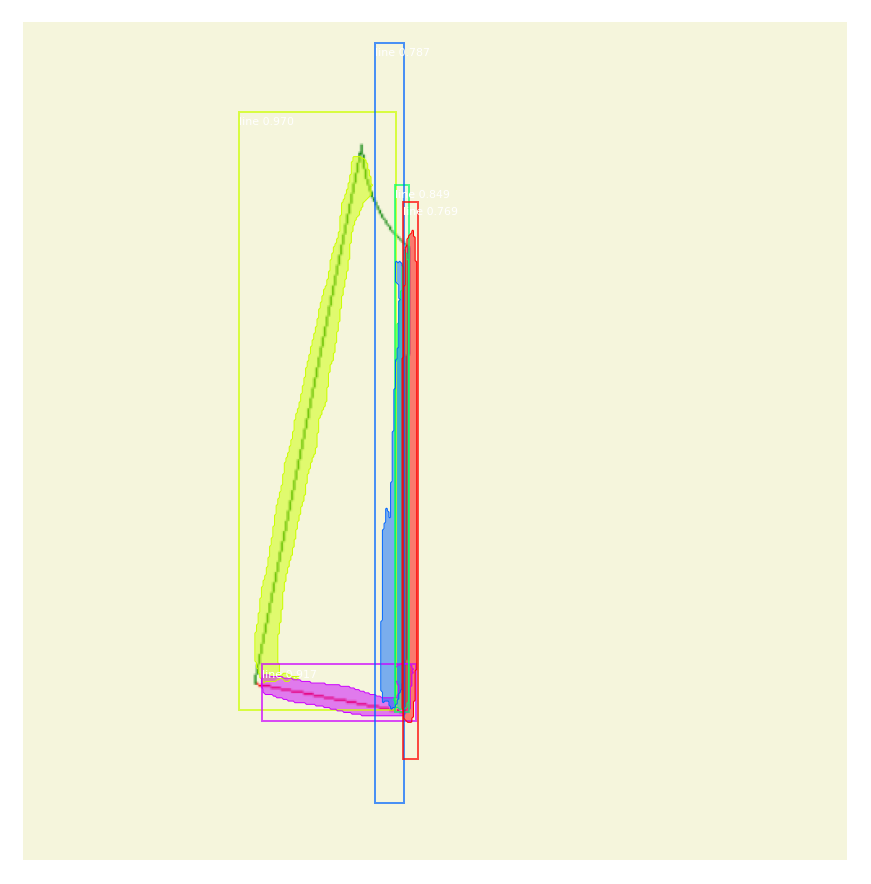

In [ ]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os

CLASS_NAMES = ['BG', 'line', 'circle']

class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = len(CLASS_NAMES)

model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

model.load_weights(filepath="object_mask_rcnn_trained.h5", 
                   by_name=True)

image = cv2.imread("./object-transfer-learning/xwdw.PNG")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

r = model.detect([image], verbose=0)

r = r[0]

mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])

Annotation json path:  ./object-transfer-learning/object/annots/annotations_train.json
Validation: 52
i----------------------------- %d 19
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


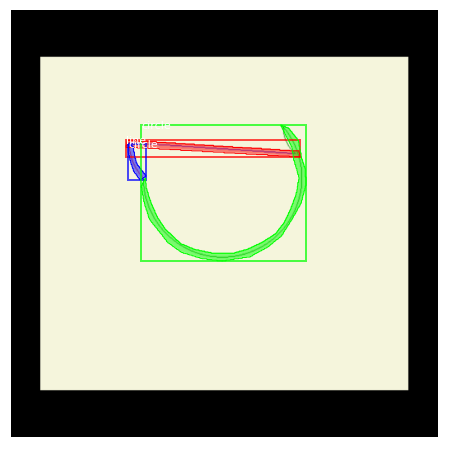

i----------------------------- %d 20
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


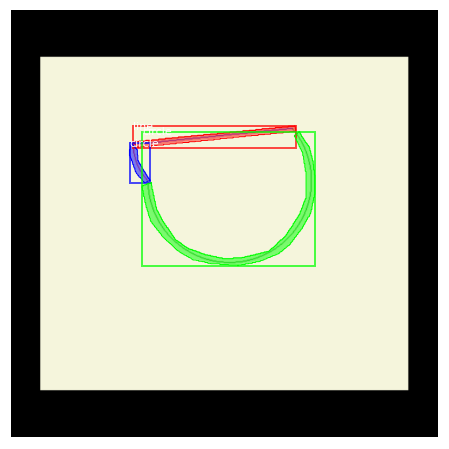

i----------------------------- %d 21
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


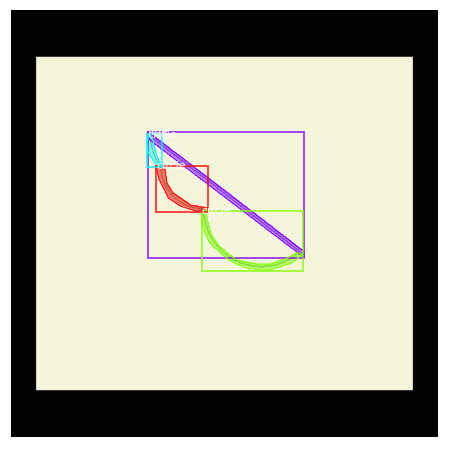

i----------------------------- %d 22
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


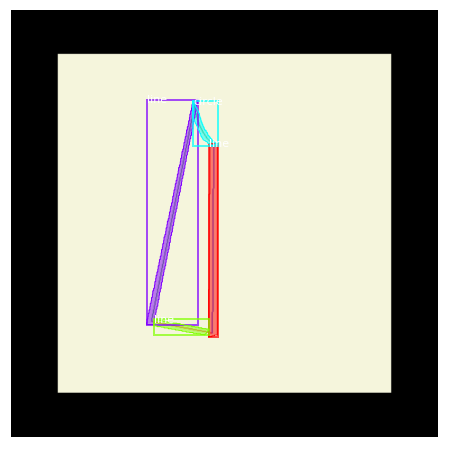

i----------------------------- %d 23
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


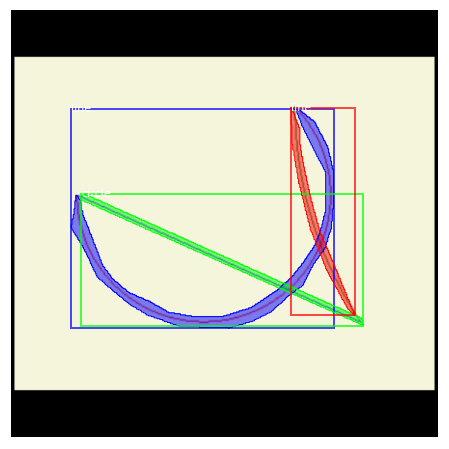

i----------------------------- %d 24
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


KeyboardInterrupt: ignored

In [ ]:
import random
import mrcnn
import mrcnn.config
import mrcnn.model
from mrcnn import visualize

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax


# Validation
validation_dataset = ObjectDataset()
validation_dataset.load_dataset(annotation_json='./object-transfer-learning/object/annots/annotations_train.json', images_dir='./object-transfer-learning/object/train', dataset_type="train")
validation_dataset.prepare()


print('Validation: %d' % len(validation_dataset.image_ids))

image_id = random.choice(validation_dataset.image_ids)



model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())
for i in range (19,53):
  print("i----------------------------- %d",i)
  original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(validation_dataset,SimpleConfig(),i, use_mini_mask=False)

# print("original_image", original_image)
# print("image_meta", image_meta)
# print("gt_class_id", gt_class_id)
# print("gt_bbox", gt_bbox)
# print("gt_mask", gt_mask)

  results = model.detect([original_image], verbose=1)
  r = results[0]

  visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                                validation_dataset.class_names, figsize=(8, 8))

